In [1]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
from keras.layers import containers, AutoEncoder, Dense
from keras import models
from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import utils.JPtools as jpt



from sklearn.cross_validation import train_test_split

/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def makePsf(x, sigma1 = 1.0, b= 0.0, sigma_ratio = 2, xc = 0, alpha = lambda x, y: x):
    sigma1 = alpha(sigma1, xc)
    I = np.exp(-0.5*((x - xc)/sigma1)**2) + b*np.exp(-0.5*((x - xc)/(sigma_ratio*sigma1))**2)
    I /= np.sum(I)*(x[1] - x[0])

    return I


def manyPsf(samples = 20, batch_size = 5000, sigma = 0.2, x_bound = 1, xc_bound = 0.4, **kwargs):
    np.random.seed(seed=42)
    X = []
    xcList = np.random.uniform(-xc_bound, xc_bound, batch_size)

    for xc in xcList:
        x0 = np.zeros(samples)
        x0[0:samples] = makePsf(np.linspace(-x_bound, x_bound, samples), sigma1 = sigma, xc = xc, **kwargs)
        X.append(x0)
    X = np.vstack(X)
    return X, xcList

def alpha_slow(sigma1, xc):
    return sigma1 * np.cos(xc)

In [3]:
X, xc = manyPsf(batch_size = 1111, alpha = alpha_slow)

network_dims = [1, 2, 4, 10, 20, 40]
act = 'relu'
init = 'glorot_normal'

network = containers.Sequential()
network.add(Dense(output_dim = 2, input_dim = 1, init = 'positive_uniform', activation = 'linear'))
for i in network_dims[1:]:
    network.add(Dense(output_dim = i, init = init, activation = act))
network.add(Dense(output_dim = 20, init = 'positive_uniform', activation = 'linear'))

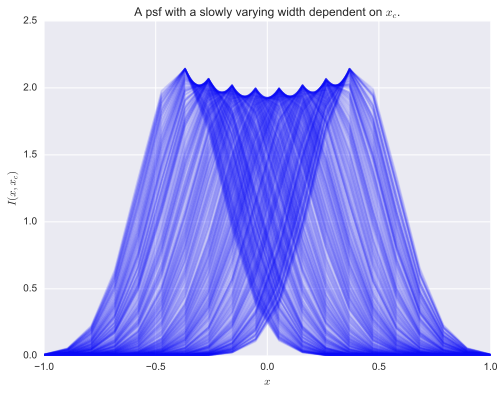

In [4]:
f = plt.figure()
f.set_size_inches(8,6)
for i in xrange(0, len(X)):
    plt.plot(np.linspace(-1,1,20), X[i], color = 'b', alpha = 0.05)
    
plt.ylabel(r'$I(x, x_c)$')
plt.xlabel(r'$x$')
plt.title(r'A psf with a slowly varying width dependent on $x_c$.')

In [5]:
model = models.Sequential()
model.add(network)
model.compile(optimizer = 'sgd', loss = 'mse')

In [6]:
X_train, X_val = train_test_split(X, test_size = 0.1, random_state = 42)
xc_train, xc_val = train_test_split(xc, test_size = 0.1, random_state = 42)



In [10]:
%%capture
model.fit(xc_train.reshape(-1,1), X_train, nb_epoch=7000)

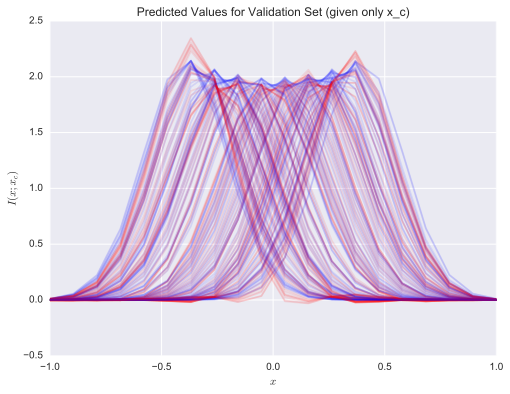

In [11]:
f = plt.figure()
f.set_size_inches(8,6)
x_pred = model.predict(xc_val.reshape(-1,1))
for i in xrange(len(xc_val)):
    plt.plot(np.linspace(-1,1,20), x_pred[i], color = 'r', alpha = 0.1)
    plt.plot(np.linspace(-1,1,20), X_val[i], color = 'b', alpha = 0.1)
    
plt.xlabel(r'$x$')
plt.ylabel(r'$I(x;x_c)$')
plt.title('Predicted Values for Validation Set (given only x_c)')

I think this might be a solution to our actual task: that is, given a network trained on some known x_c values and psf (alpha varies with x_c and is not explicitly known in the training set), recover the curve at an arbitrary x_c. Here we can predict a curve for a single value of x_c.  (There is a little cruft in the code because tensorflow doesn't like single floats so it needs a tensor.)

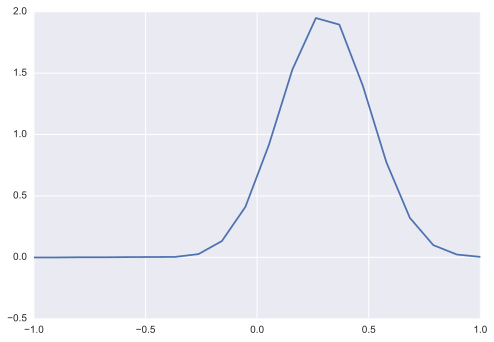

In [13]:
def predict_single(x):
    y = np.zeros(2)
    y[0] = x
    y = y.reshape(-1,1)
    return model.predict(y)[0]

plt.figure()
plt.plot(np.linspace(-1,1,20), predict_single(0.3))